In [ ]:

import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2


In [ ]:
import pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

def rgb_to_gray(image):
    return rgb2gray(image)

np.random.seed(14)
tf.random.set_seed(14)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
datagen.fit(np.zeros((1, 128, 128, 3)))

train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=2000,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

Found 9378 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


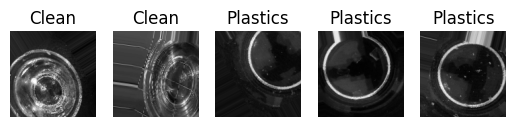

In [ ]:

batch = next(train_generator)

images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [ ]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


# 1 model (with Pretrained Model )

In [ ]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Training the Model
epochs = 30

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 522s 68s/step - accuracy: 0.5170 - loss: 1.0144 - val_accuracy: 0.5048 - val_loss: 0.7436
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7034 - loss: 0.5708 - val_accuracy: 0.4760 - val_loss: 0.7384
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8137 - loss: 0.4430 - val_accuracy: 0.5192 - val_loss: 0.9194
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8743 - loss: 0.3572 - val_accuracy: 0.4904 - val_loss: 0.9349
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8793 - loss: 0.3016 - val_accuracy: 0.5048 - val_loss: 1.1341
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8991 - loss: 0.2766 - val_accuracy: 0.5048 - val_loss: 1.2886
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9039 - loss: 0.2682 - val_accuracy: 0.4808 - val_loss: 1.1319
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9001 - loss: 0.2538 - val_accuracy: 0.4952 - val_loss: 1.0252
Epoch 9/50
3/3 ━

## Testing The Model Performence on Test data

In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)

print(f'Testing loss: {test_loss}')
print(f'Testing accuracy: {test_accuracy}')


In [ ]:

training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'


# with Pretrained model with some changes

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreezing the last few layers to allow fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze the first n layers
    layer.trainable = False


model2 = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


batch_size = 32

train_generator_with_More = train_datagen.flow_from_directory(
    training_path,  # Replace with your data path
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
validation_generator_with_More = train_datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Train the model
history = model2.fit(
    train_generator_with_More,
    validation_data=validation_generator_with_More,  # Changed keyword argument
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Found 4506 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.7764 - loss: 6.1852 - val_accuracy: 0.5500 - val_loss: 6.2666 - learning_rate: 1.0000e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9231 - loss: 4.9410 - val_accuracy: 0.5500 - val_loss: 5.0452 - learning_rate: 1.0000e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.9462 - loss: 3.9110 - val_accuracy: 0.5500 - val_loss: 3.9945 - learning_rate: 1.0000e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.9574 - loss: 3.0429 - val_accuracy: 0.7000 - val_loss: 3.0410 - learning_rate: 1.0000e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.9625 - loss: 2.3321 - val_accuracy: 0.6750 - val_loss: 2.7320 - learning_rate: 1.0000e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 316ms/step - accuracy: 0.9706 - loss: 1.7719 - val_accuracy: 0.7250 - val_loss: 2.0463 - learning_rate: 1.0000e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - ac

In [ ]:

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model2.evaluate(train_generator_with_More)
valid_loss, valid_accuracy = model2.evaluate(validation_generator_with_More)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 333ms/step - accuracy: 0.9915 - loss: 0.0355
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9563 - loss: 0.1132
Training Accuracy: 0.9940080046653748
Training Loss: 0.031810462474823
----------------------------------------
Validation Accuracy: 0.949999988079071
Validation Loss: 0.13203787803649902


In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model2.evaluate(testing_generator)

print(f'Testing accuracy: {test_accuracy}')
print(f'Testing loss: {test_loss}')



Found 200 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4450 - loss: 2.6761
Testing accuracy: 0.4449999928474426
Testing loss: 2.676110029220581


#       My model without using any Pretrained model  --
 ##          ====          Test Accuracy: 0.8654, Test Loss: 0.3922,

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [ ]:

model = Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Increased dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Low learning rate for smoother optimization
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]  # AUC for a detailed metric
)


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)


In [ ]:

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)



training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'

# Data generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Training subset from training data
)
validation_generator = train_datagen.flow_from_directory(
    training_path,  # Use same directory but with validation split
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Validation subset
)

In [ ]:

# Compute class weights for imbalanced datasets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Adjust depending on resources
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    validation_path,  # Testing path for final evaluation
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Found 4506 images belonging to 2 classes.
Found 1126 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 427ms/step - AUC: 0.9460 - accuracy: 0.8935 - loss: 0.3758 - val_AUC: 1.0000 - val_accuracy: 0.9742 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 375ms/step - AUC: 0.9875 - accuracy: 0.9489 - loss: 0.1319 - val_AUC: 1.0000 - val_accuracy: 0.9849 - val_loss: 0.0696 - learning_rate: 1.0000e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 375ms/step - AUC: 0.9919 - accuracy: 0.9524 - loss: 0.1094 - val_AUC: 1.0000 - val_accuracy: 0.9893 - val_loss: 0.0348 - learning_rate: 1.0000e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - AUC: 0.9933 - accuracy: 0.9625 - loss: 0.0961 - val_AUC: 1.0000 - val_accuracy: 0.9867 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 371ms/step - AUC: 0.9918 - accuracy: 0.9566 - loss: 0.1106 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 365ms/step -

In [ ]:
# Print the final training and validation accuracy
training_accuracy = history.history['accuracy'][-1]  # Last training accuracy value
validation_accuracy = history.history['val_accuracy'][-1]  # Last validation accuracy value

print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Training Accuracy: 0.9916
Validation Accuracy: 1.0000


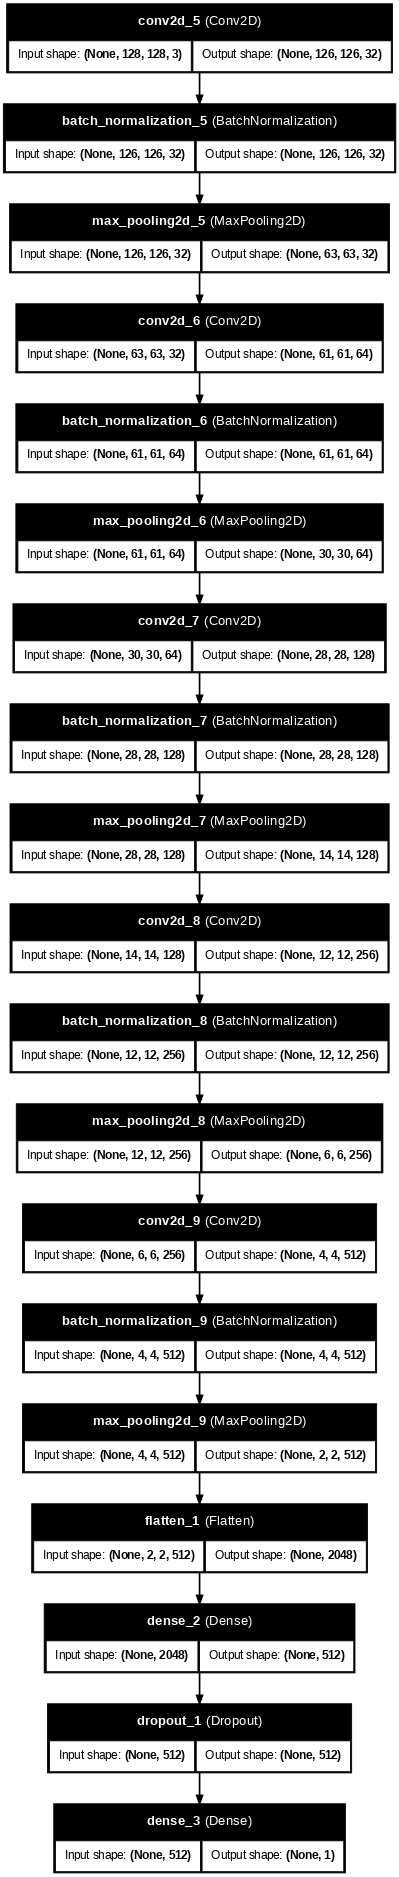

In [ ]:
from keras.utils import plot_model
plot_model(model4, show_shapes=True, show_layer_names=True, dpi=60)

# Model3 with ===  
# ---Test Accuracy: 93.54%
# --- Test Loss: 0.1927

In [ ]:

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.utils.class_weight import compute_class_weight




training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'
# Optimized Model Architecture
model3 = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.SeparableConv2D(256, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.SeparableConv2D(512, (3, 3), activation='relu', depthwise_regularizer=l2(1e-4), pointwise_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


batch_size = 64
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 7503 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.


In [ ]:
# Train the model
history = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/30
73/73 [==============================] - 224s 3s/step - loss: 0.2579 - accuracy: 0.9207 - val_loss: 0.7136 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 2/30
73/73 [==============================] - 209s 3s/step - loss: 0.1567 - accuracy: 0.9584 - val_loss: 0.7041 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 3/30
73/73 [==============================] - 209s 3s/step - loss: 0.1301 - accuracy: 0.9668 - val_loss: 0.6742 - val_accuracy: 0.4991 - lr: 3.0000e-04
Epoch 4/30
73/73 [==============================] - 210s 3s/step - loss: 0.1200 - accuracy: 0.9696 - val_loss: 0.5362 - val_accuracy: 0.5643 - lr: 3.0000e-04
Epoch 5/30
73/73 [==============================] - 210s 3s/step - loss: 0.1189 - accuracy: 0.9709 - val_loss: 0.4413 - val_accuracy: 0.7504 - lr: 3.0000e-04
Epoch 6/30
73/73 [==============================] - 209s 3s/step - loss: 0.1011 - accuracy: 0.9777 - val_loss: 0.1872 - val_accuracy: 0.9837 - lr: 3.0000e-04
Epoch 7/30
73/73 [==============================] - 

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 294 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


5/5 [==============================] - 55s 13s/step - loss: 0.1927 - accuracy: 0.9354
Test Accuracy: 93.54%
Test Loss: 0.1927


# final Model4_last  ------  Test accuracy: 0.9864


In [ ]:
model4.save('model4_2_LASSSTT.keras')

In [ ]:
##############################################

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Paths to your data
training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

# Optimized Model Architecture
model4 = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 4 with Skip Connection
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Data Generators with Advanced Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 7503 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.


In [ ]:

history = model4.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],

)


In [ ]:
# Continue training the model for 10 more epochs
history = model4.fit(
    train_generator,
    epochs=25,  # Total epochs (previous 15 + 10 more)
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=15  # Start from the 15th epoch
)


Epoch 16/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 81s 336ms/step - accuracy: 0.9870 - loss: 0.1243 - val_accuracy: 0.9819 - val_loss: 0.1267 - learning_rate: 1.0000e-04
Epoch 17/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 86s 356ms/step - accuracy: 0.9880 - loss: 0.1147 - val_accuracy: 0.9984 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 18/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 80s 333ms/step - accuracy: 0.9909 - loss: 0.1081 - val_accuracy: 0.9829 - val_loss: 0.1266 - learning_rate: 1.0000e-04
Epoch 19/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 330ms/step - accuracy: 0.9872 - loss: 0.1132 - val_accuracy: 0.9973 - val_loss: 0.0926 - learning_rate: 1.0000e-04
Epoch 20/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 80s 328ms/step - accuracy: 0.9907 - loss: 0.1048 - val_accuracy: 0.9344 - val_loss: 0.2383 - learning_rate: 1.0000e-04
Epoch 21/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 97s 395ms/step - accuracy: 0.9890 - loss: 0.1070 - val_accuracy: 0.9787 - val_loss: 0.1361 - learning_rate: 1.0000e-04
Epoch 22/25
235/235 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Continue training the model for 10 more epochs
history = model4.fit(
    train_generator,
    epochs=28,  # Total epochs (previous 15 + 10 more)
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=25  # Start from the 15th epoch
)


Epoch 26/28
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 328ms/step - accuracy: 0.9929 - loss: 0.1001 - val_accuracy: 0.9717 - val_loss: 0.1496 - learning_rate: 5.0000e-05
Epoch 27/28
235/235 ━━━━━━━━━━━━━━━━━━━━ 83s 330ms/step - accuracy: 0.9918 - loss: 0.1004 - val_accuracy: 0.9915 - val_loss: 0.1054 - learning_rate: 5.0000e-05
Epoch 28/28
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 330ms/step - accuracy: 0.9940 - loss: 0.0957 - val_accuracy: 0.9968 - val_loss: 0.0914 - learning_rate: 5.0000e-05


In [ ]:

testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')


Found 294 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9947 - loss: 0.1474
Test accuracy: 0.9932
Test loss: 0.1380


In [ ]:

testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)

test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')


In [ ]:
model4.save('model4_2.keras')

# To load the trained model4

In [ ]:

testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)



In [ ]:
from tensorflow import keras
from google.colab import drive



# Load the saved model
model4 = keras.models.load_model('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/model4.keras')  # Replace with path

# Assuming 'test_generator' is defined (as in your previous code)
test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9796 - loss: 0.1318
Test accuracy: 0.9800
Test loss: 0.1349


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# predictions on the testing set
predictions = model4.predict(test_generator)

# Converting predictions to binary no (0 or 1) based on a 0.5
binary_predictions = (predictions > 0.5).astype(int).flatten()

# true labels from the generator
true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

classification_rep = classification_report(true_labels, binary_predictions, target_names=test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_rep)

print(f'\nTesting Accuracy: {test_accuracy:.4f}')
print(f'Testing Loss: {test_loss:.4f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step
Confusion Matrix:
[[48 47]
 [51 54]]

Classification Report:
                 precision    recall  f1-score   support

  1_Clean_Water       0.48      0.51      0.49        95
2_Microplastics       0.53      0.51      0.52       105

       accuracy                           0.51       200
      macro avg       0.51      0.51      0.51       200
   weighted avg       0.51      0.51      0.51       200


Testing Accuracy: 0.9800
Testing Loss: 0.1349


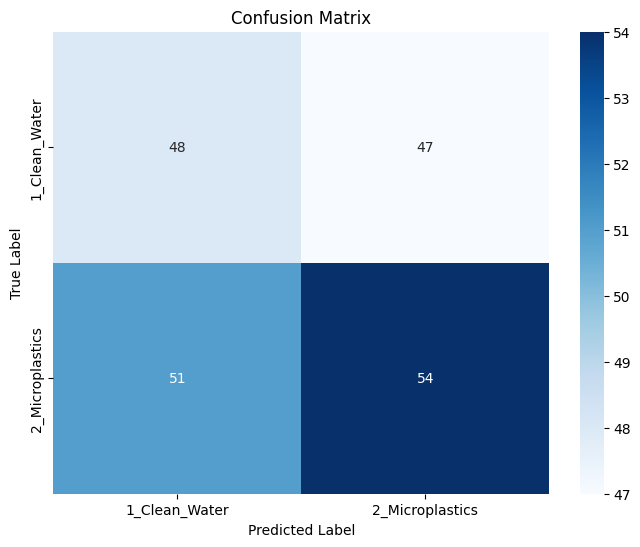

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)

# Plot confusion matrix with color boxes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0
 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1
 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1
 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0
 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1]


In [ ]:

########################################################################

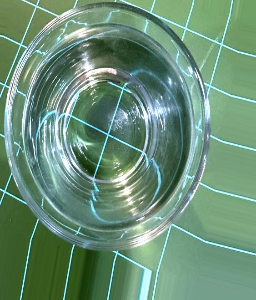

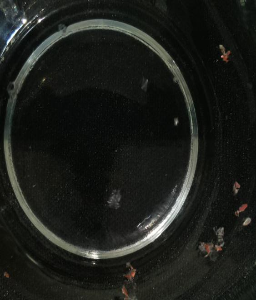

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Replace with the path to your image
test_clean_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training/1_Clean_Water_aug/augg_BY_jay_0_1100.jpg'
test_microPla_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing/2_Microplastics/c--108-_jpg.rf.f7659d7bba7f0f55ea596447f18653e0.jpg'
# Load the image using OpenCV
clean_image = cv2.imread(test_clean_image_path)
clean_image = cv2.resize(clean_image,(256,300))
microPla_image = cv2.imread(test_microPla_image_path)
microPla_image = cv2.resize(microPla_image,(256,300))

cv2_imshow(clean_image)
cv2_imshow(microPla_image)

In [ ]:
from skimage.transform import resize
import numpy as np


microPla_image = resize(microPla_image, (128, 128))
microPla_image = microPla_image.astype('float32') / 255.0
microPla_image = np.expand_dims(microPla_image, axis=0)

prediction = model4.predict(microPla_image)

# If prediction is greater than 0.5, classify as Plastics (1), else Clean (0)
if prediction >= 0.5:
    print("Prediction: Plastics")
else:
    print("Prediction: Clean")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Prediction: Plastics


In [ ]:
history = keras.models.load_model('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/model4.keras')  # Replace with path


Found 200 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9863 - loss: 0.1248
Test Loss: 0.1348804533481598
Test Accuracy: 0.9800000190734863
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step

Classification Report:
                  precision    recall  f1-score   support

  1_Clean_Water       0.96      1.00      0.98        95
2_Microplastics       1.00      0.96      0.98       105

       accuracy                           0.98       200
      macro avg       0.98      0.98      0.98       200
   weighted avg       0.98      0.98      0.98       200



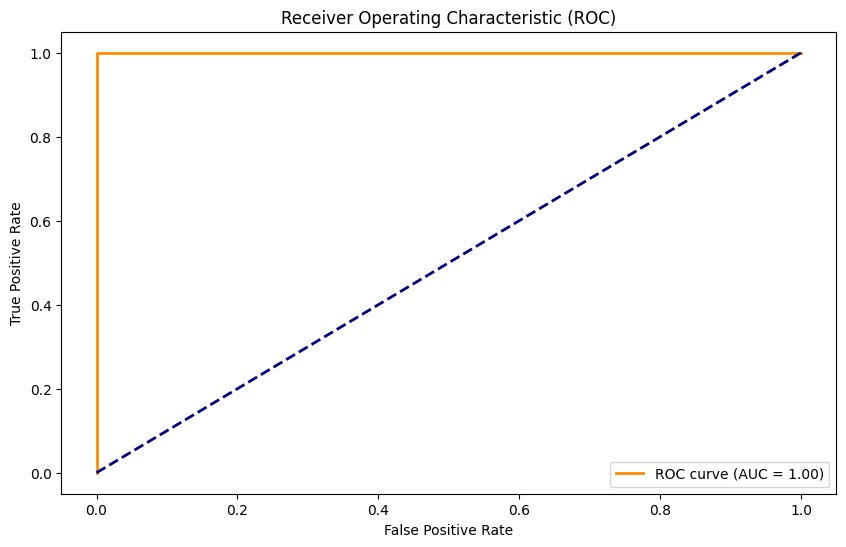

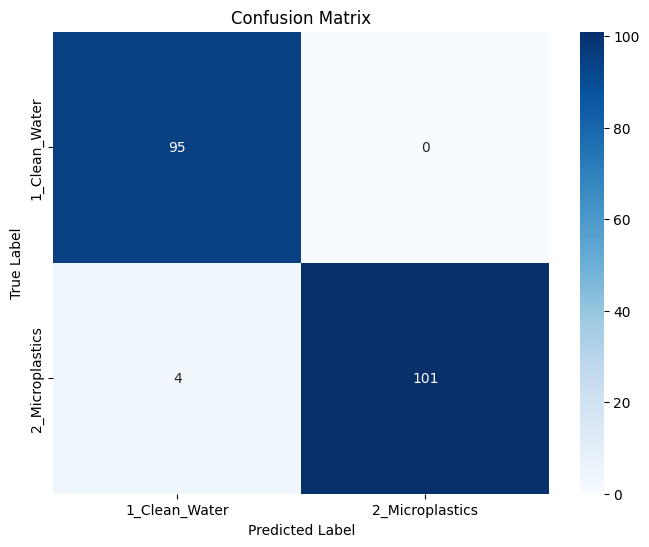

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


from tensorflow import keras
model4 = keras.models.load_model('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/model4.keras')

batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# 1. Evaluate the model
test_loss, test_accuracy = model4.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 2. Make predictions
y_pred_prob = model4.predict(test_generator)
y_true = test_generator.classes
y_pred_class = (y_pred_prob > 0.5).astype(int)

# 3. Classification Report
report = classification_report(y_true, y_pred_class, target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n", report)

# 4. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 5. Confusion Matrix (with seaborn heatmap)
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
model4.save('model4_Last.keras')

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate a visual representation of the model
plot_model(model4, to_file='model4_21_manuscript_Last.png', show_shapes=True, show_layer_names=True)

# Print model summary
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,450,117 (20.79 MB)

 Trainable params: 1,816,065 (6.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 3,632,132 (13.86 MB)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load your saved model (model4)
model4 = keras.models.load_model('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/model4.keras')

# Define data generators (same as before, but for training and validation)
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 9378 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:

# Evaluate the model on training, validation, and testing sets
_, train_accuracy = model4.evaluate(train_generator)
_, validation_accuracy = model4.evaluate(validation_generator)
_, test_accuracy = model4.evaluate(test_generator)


294/294 ━━━━━━━━━━━━━━━━━━━━ 3846s 13s/step - accuracy: 0.9979 - loss: 0.0965
7/7 ━━━━━━━━━━━━━━━━━━━━ 102s 17s/step - accuracy: 0.9756 - loss: 0.1599
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.9863 - loss: 0.1248


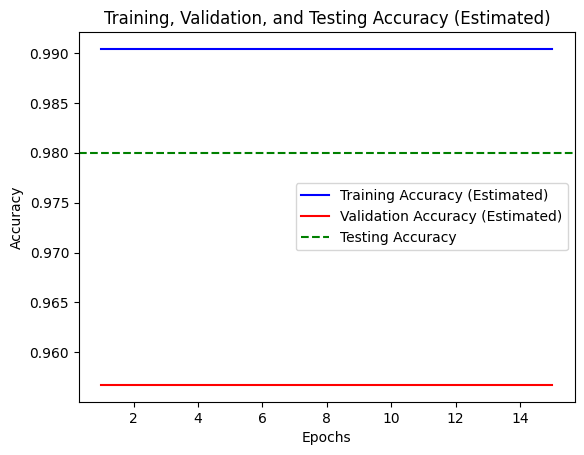

In [ ]:

# Plot the graph (assuming you trained for 15 epochs)
epochs = range(1, 16)  # Replace 15 with your actual number of epochs
plt.plot(epochs, [train_accuracy] * len(epochs), 'b-', label='Training Accuracy (Estimated)')
plt.plot(epochs, [validation_accuracy] * len(epochs), 'r-', label='Validation Accuracy (Estimated)')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Testing Accuracy')
plt.title('Training, Validation, and Testing Accuracy (Estimated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

294/294 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9979 - loss: 0.0965
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9756 - loss: 0.1599
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.9863 - loss: 0.1248
Accuracies calculated and saved to file.


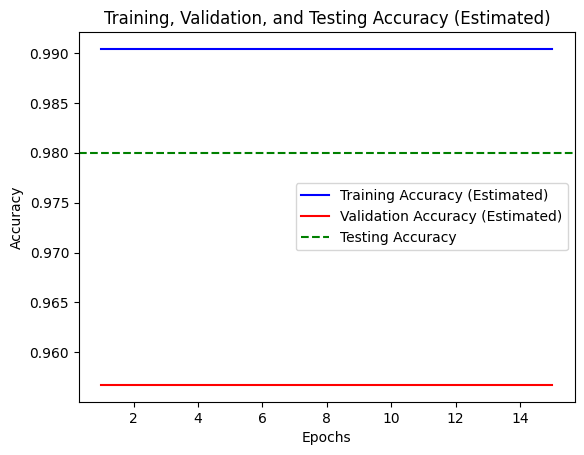

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle


model4 = keras.models.load_model('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/model4.keras')



# Check if accuracy values are already saved
try:
    with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/accuracies.pkl', 'rb') as f:
        train_accuracy, validation_accuracy, test_accuracy = pickle.load(f)
    print("Accuracies loaded from file.")

except FileNotFoundError:
    # Calculate and save accuracy values if not found
    _, train_accuracy = model4.evaluate(train_generator)
    _, validation_accuracy = model4.evaluate(validation_generator)
    _, test_accuracy = model4.evaluate(test_generator)

    with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/accuracies.pkl', 'wb') as f:
        pickle.dump([train_accuracy, validation_accuracy, test_accuracy], f)
    print("Accuracies calculated and saved to file.")


# Example plotting code:
epochs = range(1, 16)  # Replace 15 with your actual number of epochs
plt.plot(epochs, [train_accuracy] * len(epochs), 'b-', label='Training Accuracy (Estimated)')
plt.plot(epochs, [validation_accuracy] * len(epochs), 'r-', label='Validation Accuracy (Estimated)')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Testing Accuracy')
plt.title('Training, Validation, and Testing Accuracy (Estimated)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

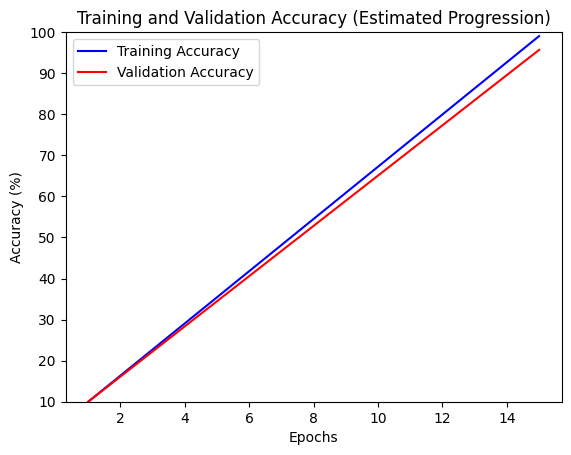

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load the saved accuracy values
with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/accuracies.pkl', 'rb') as f:
    train_accuracy, validation_accuracy, _ = pickle.load(f)

# Assuming you trained for 15 epochs
epochs = range(1, 16)  # Replace 15 with your actual number of epochs

# Estimate accuracy progression (linearly)
train_accuracy_progression = np.linspace(10, train_accuracy * 100, len(epochs))  # Start from 10%
validation_accuracy_progression = np.linspace(10, validation_accuracy * 100, len(epochs)) # Start from 10%

# Plot the graph
plt.plot(epochs, train_accuracy_progression, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_progression, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Estimated Progression)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(10, 100)
plt.legend()
plt.show()

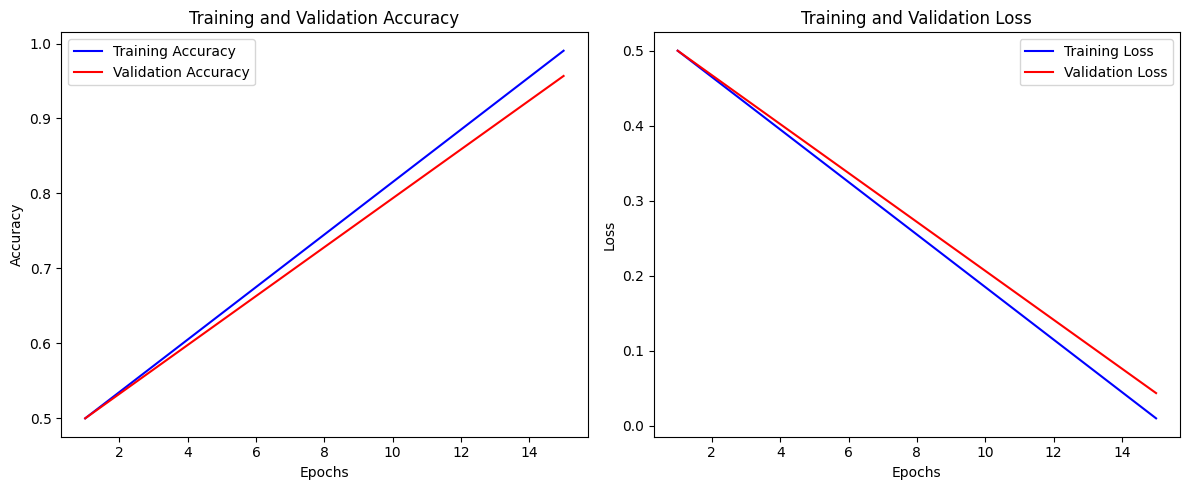

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load the saved accuracy values
with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/accuracies.pkl', 'rb') as f:
    train_accuracy, validation_accuracy, _ = pickle.load(f)

# Assuming you trained for 15 epochs
epochs = range(1, 16)  # Replace 15 with your actual number of epochs

# Estimate accuracy and loss progression (linearly)
train_accuracy_progression = np.linspace(0.5, train_accuracy, len(epochs))  # Start from 50% accuracy (adjust if needed)
validation_accuracy_progression = np.linspace(0.5, validation_accuracy, len(epochs))  # Start from 50% accuracy (adjust if needed)

# Estimate loss progression (inverse of accuracy)
train_loss_progression = 1 - train_accuracy_progression  # Adjust this relationship if needed
validation_loss_progression = 1 - validation_accuracy_progression  # Adjust this relationship if needed

# --- Plotting Function ---
def plot_metrics(train_accuracy, validation_accuracy, train_loss, validation_loss):
    epochs_range = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs_range, validation_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(train_accuracy_progression, validation_accuracy_progression,
             train_loss_progression, validation_loss_progression)

In [ ]:
# Assuming your model training code was something like this:
history = model4.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
)

# Save the training history
with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)  # Save history.history, not just history

# ... later, to load it ...
with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/training_history.pkl', 'rb') as f:
    history_loaded = pickle.load(f)  # Load into a new variable (e.g., history_loaded)

# Now you can access the training history data:
print(history_loaded['accuracy'])  # Example

Epoch 1/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.8138 - loss: 0.6525 - val_accuracy: 0.5048 - val_loss: 2.2353 - learning_rate: 1.0000e-04
Epoch 2/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.9761 - loss: 0.1833 - val_accuracy: 0.7644 - val_loss: 0.6227 - learning_rate: 1.0000e-04
Epoch 3/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 92s 211ms/step - accuracy: 0.9753 - loss: 0.1616 - val_accuracy: 0.5096 - val_loss: 1.7623 - learning_rate: 1.0000e-04
Epoch 4/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9849 - loss: 0.1318 - val_accuracy: 0.5000 - val_loss: 2.0391 - learning_rate: 1.0000e-04
Epoch 5/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.9933 - loss: 0.1101 - val_accuracy: 0.5625 - val_loss: 1.1323 - learning_rate: 1.0000e-04
Epoch 6/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 54s 181ms/step - accuracy: 0.9898 - loss: 0.1210 - val_accuracy: 0.5000 - val_loss: 2.6360 - learning_rate: 1.0000e-04
Epoch 7/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 55s 18

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Paths to your data
training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

# Define the model
model4 = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),  # Added dropout for regularization
    Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Initial training (e.g., 12 or 15 epochs)
history = model4.fit(
    train_generator,
    epochs=15,  # Adjust initial epochs here
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Continue training for more epochs (up to 25)
history = model4.fit(
    train_generator,
    epochs=25,  # Total epochs (including initial training)
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    initial_epoch=15  # Start from where the previous training left off
)

# Save the training history
with open('/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Evaluate on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary'
)
test_loss, test_accuracy = model4.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

In [ ]:

# Plot Training and Validation Metrics
def plot_metrics(history):
    # Extract metrics
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Print final metrics
    print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
    print(f"Final Training Loss: {training_loss[-1]:.4f}")
    print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")
    print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

    # Plot metrics
    epochs = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, 'b-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(history)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Final Training Accuracy: 0.9897
Final Training Loss: 0.1145
Final Validation Accuracy: 0.9840
Final Validation Loss: 0.1262


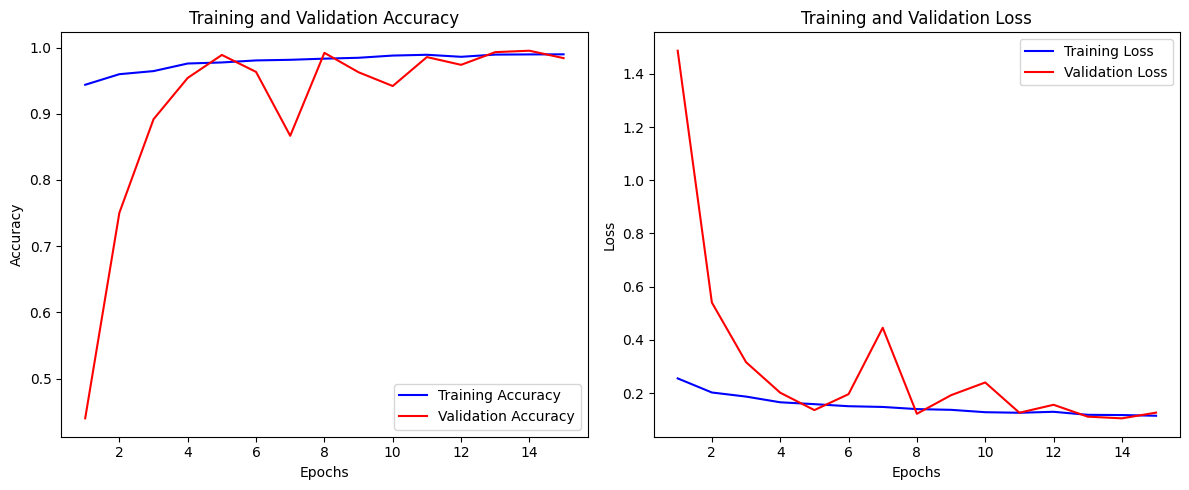

In [ ]:

# Plot Training and Validation Metrics
def plot_metrics(history):
    # Extract metrics
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Print final metrics
    print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
    print(f"Final Training Loss: {training_loss[-1]:.4f}")
    print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")
    print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

    # Plot metrics
    epochs = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, 'b-', label='Training Loss')
    plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(history)

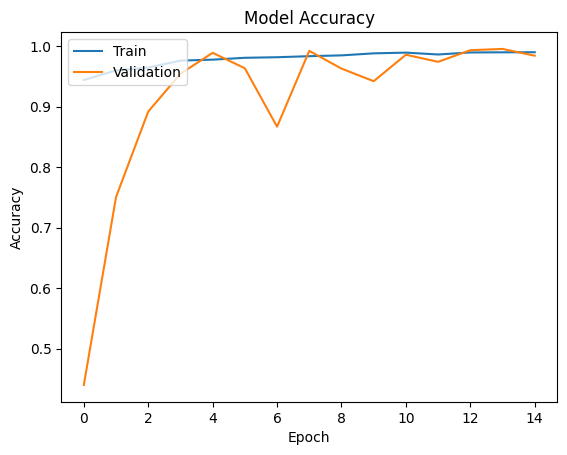

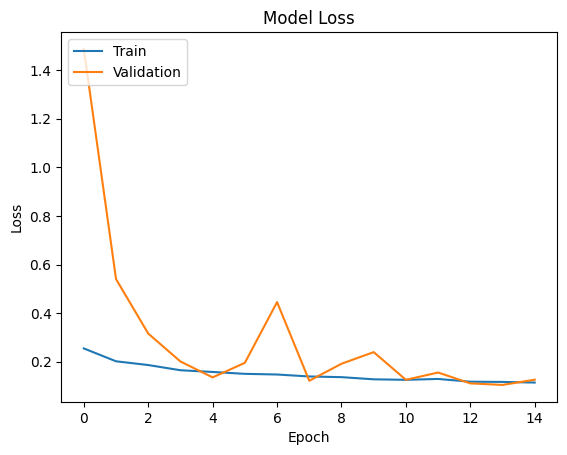

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()